In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from IPython.display import clear_output
import time

plt.rcParams.update({'font.size': 14})
from utilities import error, prepare_phi_and_S, convert1D_to_2D, plot_phi

from utilities import GS,smoothing, restriction, residual,prolongation


import matplotlib.animation as animation

from IPython import display
from matplotlib.animation import PillowWriter
metadata = dict(title='Movie', artist='cong')
# writer = PillowWriter(fps=15, metadata=metadata)
writer = PillowWriter(fps=15, metadata=metadata)

In [10]:
def TRI(N,a,d,c,Q):
    '''
    ┌                                        ┐
    │  d1  c1  0 ...                        0│
    │  a1  d2  c2  0 ...                    0│
    │        .                               │
    │          .                             │
    │            .                           │┌     ┐  ┌     ┐
    │... 0   ai-2  di-1  ci-1 0  ...         ││Phi_x│= | Q_x |
    │                  .                     │└     ┘  └     ┘
    │                   .                    │
    │                    .                   │
    │0     ... 0   aN-2  dN-1  cN-1  0  ...  │
    │0         ... 0   aN-1  dN    0  ...    │ 
    └                                        ┘
    '''
    # Tridiagonal matrix solver
    phi = np.zeros(N)

    # Forward Elemination
    for i in range (1,N):
        const = a[i-1] / d[i-1]
        d[i] = d[i] - const*c[i-1] # Diagonal
        Q[i] = Q[i] - const*Q[i-1]  # RHS
    
    # Solve last equation 
    phi[-1] = Q[-1]/d[-1]

    # Backward Elemination
    for i in range(N-2,-1,-1):
        
        phi[i] = (Q[i] - c[i]*phi[i+1]) / d[i]

    return phi

def applyBC(phi, Nx, Ny, S, L, H, convert_to_K=False):
    # This function applies BCs to 𝜙 and S
    dx = L / (Nx - 1)  # Grid size
    dy = H / (Ny - 1)  # Grid size
    ## Right BC
    i = Nx - 1
    for j in range(1, Ny - 1):

        y = j * dy
        phiR = 1000 * (0.25 * np.sinh(0.5) + (y - 0.5) ** 2 * np.sinh(y - 0.5))

        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiR
            S[k] = phiR
        else:
            phi[i, j] = phiR
            S[i, j] = phiR

    ## left BC
    i = 0
    for j in range(1, Ny - 1):

        x = i * dx
        y = j * dy

        phiL = 1000 * (0.25 * np.sinh(-0.5) + (y - 0.5) ** 2 * np.sinh(y - 0.5))

        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiL
            S[k] = phiL
        else:
            phi[i, j] = phiL
            S[i, j] = phiL

            ## Bottom BC
    j = 0
    for i in range(Nx):

        x = i * dx
        y = j * dy

        phiB = 1000 * (0.25 * np.sinh(-0.5) + (x - 0.5) ** 2 * np.sinh(x - 0.5))
        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiB
            S[k] = phiB
        else:
            phi[i, j] = phiB
            S[i, j] = phiB

    ## Top BC
    j = Ny - 1
    for i in range(Nx):

        x = i * dx
        y = j * dy

        phiT = 1000 * (0.25 * np.sinh(0.5) + (x - 0.5) ** 2 * np.sinh(x - 0.5))

        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiT
            S[k] = phiT
        else:
            phi[i, j] = phiT
            S[i, j] = phiT

    return phi, S


def prepare_phi_and_S(Nx, Ny, L, H, convert_to_K=False):
    # Generate RHS source terms matrix and unknowns 'phi' with Dirichlet BCs
    S = np.zeros((Nx, Ny))
    phi = np.zeros((Nx, Ny))
    dx = L / (Nx - 1)  # Grid size
    dy = H / (Ny - 1)  # Grid size
    # RHS source terms
    for i in range(Nx):
        for j in range(Ny):
            x = i * dx
            y = j * dy

            source = 1000 * (
                    2 * np.sinh(x - 0.5) + 4 * (x - 0.5) * np.cosh(x - 0.5) + (x - 0.5) ** 2 * np.sinh(x - 0.5))
            + 1000 * (2 * np.sinh(y - 0.5) + 4 * (y - 0.5) * np.cosh(y - 0.5) + (y - 0.5) ** 2 * np.sinh(y - 0.5))

            S[i, j] = -source

    phi, S = applyBC(phi, Nx, Ny, S, L, H)

    return phi, S

def prepare_phi_and_S2(Nx, Ny, L, H, convert_to_K=False):
    # Generate RHS source terms matrix and unknowns 'phi' with Dirichlet BCs
    S = np.zeros((Nx, Ny))
    phi = np.zeros((Nx, Ny))
    dx = L / (Nx - 1)  # Grid size
    dy = H / (Ny - 1)  # Grid size
    # RHS source terms
    for i in range(Nx):
        for j in range(Ny):
            x = i * dx
            y = j * dy

            source = (
                    2 * np.sinh(x - 0.5) + 4 * (x - 0.5) * np.cosh(x - 0.5) + (x - 0.5) ** 2 * np.sinh(x - 0.5))
            + 1000 * (2 * np.sinh(y - 0.5) + 4 * (y - 0.5) * np.cosh(y - 0.5) + (y - 0.5) ** 2 * np.sinh(y - 0.5))

            S[i, j] = -source

    phi, S = applyBC(phi, Nx, Ny, S, L, H)

    return phi, S

### Parameters

In [11]:
start = time.time()
Nx = 41
Ny = 41
L = 1  # length
H = 1  # length

dx = L / (Nx - 1)  # Grid size
dy = L / (Ny - 1)  # Grid size

t = 0
alpha = 1
tol = 1e-6

# maximum time step according to stability analysis
dtmax = (0.5 / alpha) / (1 / dx ** 2 + 1 / dy ** 2)

# an implicit method can use larger time step
dt = 5 * dtmax

phi, S = prepare_phi_and_S(Nx, Ny, L, H)
phi_s = np.zeros(phi.shape)
transient = True

In [12]:
def ADI_row_sweep(Nx,Ny,phi,phi_s,dt,alpha,S):
    # A function to perform row-wise sweep for ADI method

    # phi_s is the 
    phi_s = np.zeros(phi.shape)

    c = np.zeros(Nx - 1)
    a = np.zeros(Nx - 1)
    d = np.zeros(Nx)
    Q = np.zeros(Nx)
    for j in range(1, Ny - 1):

        # For Dirichlet BC
        d[0] = 1

        # Left BC
        Q[0] = phi[0, j]

        for i in range(1, Nx - 1):
            # Coefficient for Tridiagonal matrix solver
            d[i] = 1 / dt + 2 * alpha / dx ** 2
            a[i - 1] = -alpha / dx ** 2
            c[i] = -alpha / dx ** 2

            # RHS for Tri matrix
            Q[i] = S[i, j] + phi[i, j] / dt + alpha / dy ** 2 * (phi[i, j + 1] - 2 * phi[i, j] + phi[i, j - 1])

        # For Dirichlet BC
        d[Nx - 1] = 1

        # Right BC
        Q[Nx - 1] = phi[-1, j]

        # Solve for current row
        phix = TRI(Nx, a, d, c, Q)

        phi_s[:, j] = phix
    return phi_s

def ADI_column_sweep(Nx,Ny,phi,phi_s,dt,alpha,S):
    # A function to perform row-wise sweep for ADI method
    # Column-wise sweep
    c = np.zeros(Ny - 1)
    a = np.zeros(Ny - 1)
    d = np.zeros(Ny)
    Q = np.zeros(Ny)
    for i in range(1, Nx - 1):

        # For Dirichlet BC
        d[0] = 1

        # Bottom BC
        Q[0] = phi[i, 0]

        for j in range(1, Ny - 1):
            d[j] = 1 / dt + 2 * alpha / dy ** 2
            a[j - 1] = -alpha / dy ** 2
            c[j] = -alpha / dy ** 2

            # RHS for Tri matrix
            Q[j] = phi_s[i, j] / dt - alpha / dy ** 2 * (phi[i, j + 1] - 2 * phi[i, j] + phi[i, j - 1])

        # For Dirichlet BC
        d[Ny - 1] = 1

        # Top BC
        Q[Ny - 1] = phi[i, -1]

        # Solve for current row
        phix = TRI(Ny, a, d, c, Q)

        # Update current new row solution
        phi[i, :] = phix
    
    return phi

### Setting up animation frame

In [25]:
total_n=100

fig = plt.figure(figsize=(10,6))
x, y = np.meshgrid(np.linspace(0, 1, Nx), np.linspace(0, 1, Ny), indexing='ij')            
plt.xlabel('Distance, x')
plt.ylabel('Distance, y')
with writer.saving(fig, "9.5notebook_transient.gif", 100):
    if transient:
        with tqdm_notebook(range(total_n)) as t:
            for n in t:
                # Progress bar update 
                description = 'Time: ' + str(n*dt)
                t.set_description(desc=description[:14])

                phi_s =ADI_row_sweep(Nx,Ny,phi,phi_s,dt,alpha,S)

                phi   = ADI_column_sweep(Nx,Ny,phi,phi_s,dt,alpha,S)
                
                # add frame to animation every 2 time steps
                if n % 2 ==0: 
                    plt.contourf(x, y, phi)
                    plt.title('Numerical solution by ' + 'method_name' + ' iterative solver, code by Congcong Fan')
                    tt = str(n*dt)[:4]+'s'
                    plt.annotate(tt,(0.1,0.1),c='white')
                    writer.grab_frame()
                    plt.cla()
plt.close()

/var/folders/q9/8vn_nzj55b55_336zczh1y2c0000gp/T/ipykernel_7059/2676057808.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm_notebook(range(total_n)) as t:


  0%|          | 0/100 [00:00<?, ?it/s]

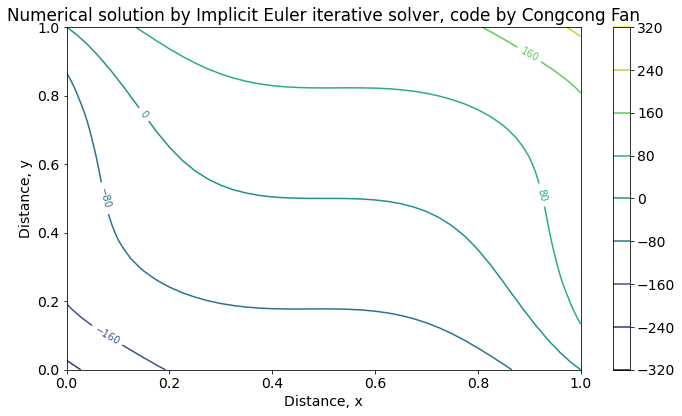

In [28]:
plot_phi(phi,None, Nx,Ny, 'Implicit Euler', convert=False)